In [11]:
%matplotlib inline

REPO_ROOT = "/usr/src/app"

import collections
import json
import math
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import tensorflow as tf

import util
reload(util)

<module 'util' from 'util.py'>

In [209]:
with open("%s/model-data/metadata.pickle" % (REPO_ROOT,), "r") as f:
    size_data = pickle.load(f)
    
TRAIN_SIZES = size_data["train_sizes"]
TEST_SIZE = size_data["test_size"]

BATCH_SIZE = 100
VOCAB_SIZE = 5000
WORD_EMBEDDING_SIZE = 400
DOC_EMBEDDING_SIZE = 1000
CONTEXT_SIZE = 3

VALIDATE_SIZE = 400

In [190]:
with open("%s/scripts/table_balanced.json" % REPO_ROOT) as f:
    data_table = json.load(f)

In [12]:
counts = collections.Counter()
print "Tokenizing %d scripts..." % len(data_table)
for idx, script in enumerate(data_table):
    if idx % 50000 == 0:
        print "%d done." % idx

    if idx % 15 != 0:
        continue
        
    with open("%s/scripts/%s.js" % (REPO_ROOT, script["sha"])) as f:
        js = f.read()
        tokens = util.tokenize_js(js)
        counts.update(tokens)

Tokenizing 530219 scripts...
0 done.
50000 done.
100000 done.
150000 done.
200000 done.
250000 done.
300000 done.
350000 done.
400000 done.
450000 done.
500000 done.


In [13]:
for token, count in counts.most_common(100):
    print "%s: %d" % (token, count)

x: 28331104
.: 17854468
): 15889942
(: 15881514
,: 14330459
{: 5235564
}: 5222394
this: 3327989
function: 2591177
+: 2453384
0: 1974836
var: 1716943
return: 1683651
if: 1532860
1: 1023792
*: 856729
length: 573219
null: 515592
for: 405828
"": 400338
/: 378967
else: 296355
typeof: 276250
_: 266460
options: 264958
new: 257706
prototype: 248212
data: 230699
2: 229309
type: 220031
document: 209109
push: 208428
element: 200757
call: 196802
value: 194601
window: 182624
event: 181193
jquery: 173435
in: 173305
style: 172981
true: 172158
false: 170870
css: 165436
arguments: 154529
test: 153669
each: 145340
width: 140208
name: 138629
void: 136536
-1: 133379
height: 127944
elem: 127732
attr: 126929
id: 126758
3: 126673
find: 125222
replace: 123812
fn: 122214
math: 121779
get: 119299
nodetype: 118291
left: 116905
top: 114701
break: 112558
extend: 109403
apply: 104481
" ": 100488
parentnode: 97412
indexof: 97086
case: 93813
target: 93354
-: 89724
the: 88561
addclass: 85638
opts: 82470
tolowercase: 8

In [134]:
word_table = {
    entry[0]: idx
    for idx, entry in enumerate(counts.most_common(VOCAB_SIZE-1))
}

with open("%s/model-data/js-vocab.pickle" % (REPO_ROOT,), "w") as f:
    pickle.dump(word_table, f)

def numerize(word):
    return word_table.get(word, VOCAB_SIZE-1)

In [221]:
def embedding_lookup(embeddings, table_rows):
    vocab_size, embed_size = np.shape(embeddings)
    embeddings_trans = np.transpose(embeddings)

    ret = np.zeros([len(table_rows), embed_size])
    for script_idx, script in enumerate(util.parse_js(table_rows)):
        token_ids = [
            numerize(token)
            for token in util.tokenize_js(script)
        ]
        word_vec = np.zeros(vocab_size)
        for token_id in token_ids:
            word_vec[token_id] += 1

        ret[script_idx] = np.matmul(embeddings_trans, word_vec)

    return ret

def save_training_set(embeddings, data_table, train_indices, test_indices):   
    data = {
        "X_train": embedding_lookup(embeddings, [data_table[index] for index in train_indices]),
        "Y_train": np.array([data_table[index]["flag-any"] for index in train_indices]),
        "X_test": embedding_lookup(embeddings, [data_table[index] for index in test_indices]),
        "Y_test": np.array([data_table[index]["flag-any"] for index in test_indices]),
    }

    with open("%s/model-data/dataset_Word2Vec_%d.pickle" % (REPO_ROOT, len(train_indices)), "w") as f:
        pickle.dump(data, f)

In [216]:
# Word2Vec algorithm
class WordEmbeddingGraph(object):
    def __init__(self, data_table, batch_size, vocabulary_size, embedding_size, context_size,
                 train_size, test_size):
        
        self.batch_size = batch_size
        self.context_size = context_size
        self.train_size = train_size
        
        random.seed(9812)
        indices = random.sample(range(len(data_table)), train_size + test_size)
        self.train_indices = indices[:train_size]
        self.validate_indices = indices[-test_size:]

        self.graph = tf.Graph()
        with self.graph.as_default():    
            self.embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),
                name="word_embeddings")

            norm = tf.sqrt(tf.reduce_sum(tf.square(self.embeddings), 1, keep_dims=True))
            self.normalized_embeddings = self.embeddings / norm

            nce_weights = tf.Variable(
              tf.truncated_normal([vocabulary_size, embedding_size],
                                  stddev=1.0 / math.sqrt(embedding_size)))
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

            self.x_ph = tf.placeholder(tf.int32, shape=[batch_size,CONTEXT_SIZE])
            self.y_ph = tf.placeholder(tf.int32, shape=[batch_size,1])

            embed = tf.add_n(
                [tf.nn.embedding_lookup(self.embeddings, self.x_ph[:,idx]) for idx in xrange(CONTEXT_SIZE)])

            # Compute the NCE loss, using a sample of the negative labels each time.
            self.loss = tf.reduce_mean(
                tf.nn.nce_loss(nce_weights, nce_biases, embed, self.y_ph,
                               64, vocabulary_size))

            output = tf.transpose(tf.matmul(nce_weights, tf.transpose(embed))) + nce_biases
            self.y_pred = tf.argmax(tf.nn.softmax(output), 1)

            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(self.loss)
            
    def generate_batch(self, indices, sample_ratio):
        x = np.ndarray(shape=(self.batch_size, self.context_size), dtype=np.int32)
        y = np.ndarray(shape=(self.batch_size,1), dtype=np.int32)
        batch_idx = 0
        for index in indices:
            with open("%s/scripts/%s.js" % (REPO_ROOT, data_table[index]["sha"])) as f:
                js = f.read()
                tokens = [numerize(token) for token in util.tokenize_js(js)]
                if len(tokens) < self.context_size + 1:
                    continue

                sample_size = len(tokens) - 1 - self.context_size
                num_to_sample = max(1, int(math.floor(sample_size * sample_ratio)))
                for pos in random.sample(range(0, sample_size + 1), num_to_sample):
                    for idx in xrange(self.context_size):
                        x[batch_idx,idx] = tokens[pos+idx]
                    y[batch_idx,0] = tokens[pos + self.context_size]
                    batch_idx += 1
                    if batch_idx == self.batch_size:
                        yield {self.x_ph: x, self.y_ph: y}
                        batch_idx = 0
                        
    def train(self, session):
        tf.initialize_all_variables().run()

        batch_idx = 1
        average_loss = 0
        for feed_dict in self.generate_batch(self.train_indices, 1.0):
            _, cur_loss = session.run([self.optimizer, self.loss], feed_dict=feed_dict)
            average_loss += cur_loss

            if batch_idx % 2000 == 0:
                validate_batches = 0
                average_accuracy = 0
                for feed_dict2 in self.generate_batch(self.validate_indices, 0.01):
                    predicted_labels = session.run([self.y_pred], feed_dict=feed_dict2)
                    predicted_labels = np.transpose(predicted_labels)
                    average_accuracy += (
                        float(np.count_nonzero(feed_dict2[self.y_ph] == predicted_labels)) / BATCH_SIZE)
                    validate_batches += 1

                print "%d Loss: %f, Accuracy: %f" % (
                    batch_idx,
                    average_loss / 1999,
                    average_accuracy / validate_batches)
                average_loss = 0

            batch_idx += 1

In [217]:
for train_size in TRAIN_SIZES:
    print "Word2Vec Training size %d" % train_size
    
    g = WordEmbeddingGraph(
        data_table, BATCH_SIZE, VOCAB_SIZE, WORD_EMBEDDING_SIZE, CONTEXT_SIZE, train_size, TEST_SIZE)

    with tf.Session(graph=g.graph) as session:
        g.train(session)
        save_training_set(g.normalized_embeddings.eval(), data_table, g.train_indices, g.validate_indices)
    
print "Done training."

Word2Vec Training size 300
2000 Loss: 34.348054, Accuracy: 0.000571
4000 Loss: 7.657447, Accuracy: 0.038525
6000 Loss: 5.936858, Accuracy: 0.181195
8000 Loss: 5.086708, Accuracy: 0.131309
Word2Vec Training size 600
2000 Loss: 35.436706, Accuracy: 0.001678
4000 Loss: 7.578258, Accuracy: 0.097875
6000 Loss: 5.970255, Accuracy: 0.207991
8000 Loss: 5.119888, Accuracy: 0.258002
10000 Loss: 5.659006, Accuracy: 0.136843
12000 Loss: 6.592877, Accuracy: 0.131567
14000 Loss: 4.722921, Accuracy: 0.207196
16000 Loss: 4.459302, Accuracy: 0.162147
18000 Loss: 4.842848, Accuracy: 0.246871
20000 Loss: 5.515647, Accuracy: 0.173631
22000 Loss: 4.640082, Accuracy: 0.197219
24000 Loss: 4.399393, Accuracy: 0.247119
26000 Loss: 3.851517, Accuracy: 0.148714
Word2Vec Training size 1200
2000 Loss: 35.044452, Accuracy: 0.000568


KeyboardInterrupt: 

In [153]:
model = TSNE(n_components=2, random_state=0)
points = model.fit_transform(final_embeddings)

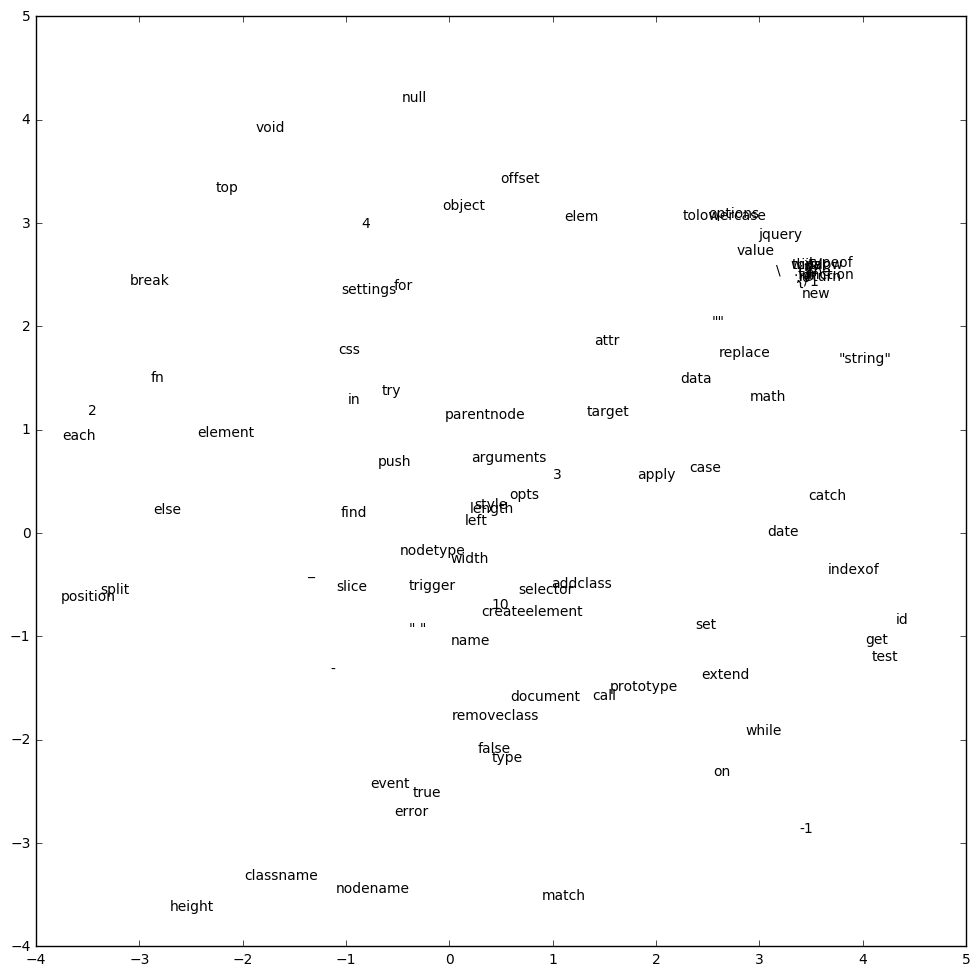

In [154]:
words = [entry[0] for entry in counts.most_common(VOCAB_SIZE-1)] + ["UNK"]

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(points[:100,0], points[:100,1], 'bo', markersize=0)

for i, txt in enumerate(words[:100]):
    ax.annotate(txt, (points[i][0],points[i][1]))

In [214]:
# Doc2Vec algorithm
class DocEmbeddingGraph(object):
    def __init__(self, data_table, batch_size, vocabulary_size, doc_embedding_size,
                 word_embedding_size, context_size, train_size, test_size,
                 word_embeddings=None, nce_weights=None, nce_biases=None, use_test=False):
        
        self.batch_size = batch_size
        self.context_size = context_size
        
        random.seed(9812)
        indices = random.sample(range(len(data_table)), train_size + test_size)
        if not use_test:
            self.train_indices = indices[:train_size]
        else:
            self.train_indices = indices[-test_size:]

        self.graph = tf.Graph()

        with self.graph.as_default():    
            self.doc_embeddings = tf.Variable(
                tf.random_uniform([len(self.train_indices), doc_embedding_size], -1.0, 1.0),
                name="doc_embeddings")

            if word_embeddings is None:
                self.word_embeddings = tf.Variable(
                    tf.random_uniform([vocabulary_size, word_embedding_size], -1.0, 1.0),
                    name="word_embeddings")
            else:
                self.word_embeddings = tf.constant(word_embeddings, name="word_embeddings")

            all_embedding_size = doc_embedding_size + word_embedding_size

            norm = tf.sqrt(tf.reduce_sum(tf.square(self.doc_embeddings), 1, keep_dims=True))
            self.normalized_doc_embeddings = self.doc_embeddings / norm

            norm = tf.sqrt(tf.reduce_sum(tf.square(self.word_embeddings), 1, keep_dims=True))
            self.normalized_word_embeddings = self.word_embeddings / norm

            if nce_weights is None:
                self.nce_weights = tf.Variable(
                  tf.truncated_normal([vocabulary_size, all_embedding_size],
                                      stddev=1.0 / math.sqrt(all_embedding_size)))
            else:
                self.nce_weights = tf.constant(nce_weights)
            
            if nce_biases is None:
                self.nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
            else:
                self.nce_biases = tf.constant(nce_biases)

            self.x_ph = tf.placeholder(tf.int32, shape=[batch_size,CONTEXT_SIZE])
            self.doc_ph = tf.placeholder(tf.int32, shape=[batch_size])
            self.y_ph = tf.placeholder(tf.int32, shape=[batch_size,1])

            doc_embed = tf.nn.embedding_lookup(self.doc_embeddings, self.doc_ph)
            words_embed = tf.add_n(
                [tf.nn.embedding_lookup(self.word_embeddings, self.x_ph[:,idx]) for idx in xrange(CONTEXT_SIZE)])

            embed = tf.concat(1, [doc_embed, words_embed])

            # Compute the NCE loss, using a sample of the negative labels each time.
            self.loss = tf.reduce_mean(
                tf.nn.nce_loss(self.nce_weights, self.nce_biases, embed, self.y_ph,
                               64, vocabulary_size))

            output = tf.transpose(tf.matmul(self.nce_weights, tf.transpose(embed))) + self.nce_biases
            self.y_pred = tf.argmax(tf.nn.softmax(output), 1)

            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(self.loss)
            
    def generate_batch(self, indices, sample_ratio):
        x = np.ndarray(shape=(self.batch_size, self.context_size), dtype=np.int32)
        di = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        y = np.ndarray(shape=(self.batch_size,1), dtype=np.int32)
        batch_idx = 0
        for doc_idx, index in enumerate(indices):
            with open("%s/scripts/%s.js" % (REPO_ROOT, data_table[index]["sha"])) as f:
                js = f.read()
                tokens = [numerize(token) for token in util.tokenize_js(js)]
                if len(tokens) < self.context_size + 1:
                    continue

                sample_size = len(tokens) - 1 - self.context_size
                num_to_sample = max(1, int(math.floor(sample_size * sample_ratio)))
                for pos in random.sample(range(0, sample_size + 1), num_to_sample):
                    di[batch_idx] = doc_idx
                    for idx in xrange(self.context_size):
                        x[batch_idx,idx] = tokens[pos+idx]
                    y[batch_idx,0] = tokens[pos+self.context_size]
                    batch_idx += 1
                    if batch_idx == self.batch_size:
                        yield {self.x_ph: x, self.doc_ph: di, self.y_ph: y}
                        batch_idx = 0
                        
    def train(self, session):
        tf.initialize_all_variables().run()

        batch_idx = 1
        average_loss = 0
        for feed_dict in self.generate_batch(self.train_indices, 1.0):
            _, cur_loss = session.run([self.optimizer, self.loss], feed_dict=feed_dict)
            average_loss += cur_loss

            if batch_idx % 2000 == 0:
                print "%d Loss: %f" % batch_idx
                average_loss = 0

            batch_idx += 1                         

In [222]:
model_data = {}

for train_size in TRAIN_SIZES:
    print "Doc2Vec Training size %d" % train_size
    
    g = DocEmbeddingGraph(
        data_table, BATCH_SIZE, VOCAB_SIZE, DOC_EMBEDDING_SIZE, WORD_EMBEDDING_SIZE, CONTEXT_SIZE,
        train_size, TEST_SIZE)

    with tf.Session(graph=g.graph) as session:
        g.train(session)

        model_data["X_train"] = g.doc_embeddings.eval()
        model_data["Y_train"] = np.array([data_table[index]["flag-any"] for index in g.train_indices])

        word_embeddings = g.word_embeddings.eval()
        nce_weights = g.nce_weights.eval()
        nce_biases = g.nce_biases.eval()

        print "Done training. Embeddings: %s, %s, NCE weights %s, %s" % (
            np.shape(model_data["X_train"]), np.shape(word_embeddings),
            np.shape(nce_weights), np.shape(nce_biases))
        
        save_training_set(g.normalized_word_embeddings.eval(), data_table, g.train_indices, g.validate_indices)

    g2 = DocEmbeddingGraph(
        data_table, BATCH_SIZE, VOCAB_SIZE, DOC_EMBEDDING_SIZE, WORD_EMBEDDING_SIZE, CONTEXT_SIZE,
        train_size, TEST_SIZE, word_embeddings, nce_weights, nce_biases, True)

    with tf.Session(graph=g2.graph) as session:
        g2.train(session)

        model_data["X_test"] = g2.doc_embeddings.eval()
        model_data["Y_test"] = np.array([data_table[index]["flag-any"] for index in g2.train_indices])

        print "Done projecting test set. %s" % (np.shape(model_data["X_test"]),)

    with open("%s/model-data/dataset_Doc2Vec_%d.pickle" % (REPO_ROOT, train_size), "w") as f:
        pickle.dump(model_data, f)

Doc2Vec Training size 300
2000 Loss: 34.122483, Accuracy: 0.000000
4000 Loss: 7.424979, Accuracy: 0.000000
6000 Loss: 5.765040, Accuracy: 0.000000
8000 Loss: 5.350085, Accuracy: 0.000000
Done training. Embeddings: (300, 1000), (5000, 400), NCE weights (5000, 1400), (5000,)
2000 Loss: 7.183969, Accuracy: 0.000000
4000 Loss: 6.278988, Accuracy: 0.000000
6000 Loss: 5.390398, Accuracy: 0.000000
8000 Loss: 5.338095, Accuracy: 0.000000
10000 Loss: 6.504556, Accuracy: 0.000000
12000 Loss: 5.525290, Accuracy: 0.000000
14000 Loss: 5.139655, Accuracy: 0.000000
16000 Loss: 5.542978, Accuracy: 0.000000
18000 Loss: 6.632132, Accuracy: 0.000000
20000 Loss: 7.032404, Accuracy: 0.000000
22000 Loss: 6.863797, Accuracy: 0.000000
24000 Loss: 7.285928, Accuracy: 0.000000
26000 Loss: 6.236211, Accuracy: 0.000000
28000 Loss: 5.953755, Accuracy: 0.000000
30000 Loss: 4.571380, Accuracy: 0.000000
32000 Loss: 4.528425, Accuracy: 0.000000
34000 Loss: 4.673684, Accuracy: 0.000000
36000 Loss: 6.339206, Accuracy: 0

KeyboardInterrupt: 